# Imports

In [1]:
import math
import pandas as pd
import numpy as np
import madmom as mm
import librosa as lr
import pretty_midi as pm
import librosa.display as display
import IPython.display as ipd
import matplotlib.pyplot as plt
from magenta.models.nsynth import utils

from magenta.models.nsynth.wavenet import fastgen

from sklearn.preprocessing import MinMaxScaler

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


# Constants

In [4]:
# Local
DATAPOINT = "../datasets/maps/CH/" + \
            "MAPS_ISOL_CH0.1_F_SptkBGAm.wav"
MIDI_DATAPOINT = "../datasets/maps/CH/" + \
        "MAPS_ISOL_CH0.1_F_SptkBGAm.mid"

OTHER_DATAPOINT = "../datasets/maps/C0-1-3-4-8/" + \
             "MAPS_UCHO_C0-1-3-4-8_I32-96_S0_n1_ENSTDkAm.wav"
OTHER_DATAPOINT_NAME = "MAPS_UCHO_C0-1-3-4-8_I32-96_S0_n1_ENSTDkAm.wav"
OTHER_MIDI_DATAPOINT = "../datasets/maps/C0-1-3-4-8/" + \
         "MAPS_UCHO_C0-1-3-4-8_I32-96_S0_n1_ENSTDkAm.mid"

# # Remote 
# DATAPOINT = "../datasets/maps/AkPnBcht/ISOL/CH/" + \
#             "MAPS_ISOL_CH0.05_F_AkPnBcht.wav"
# MIDI_DATAPOINT = "../datasets/maps/AkPnBcht/ISOL/CH/" + \
#             "MAPS_ISOL_CH0.05_F_AkPnBcht.mid"
    
# OTHER_DATAPOINT = "../datasets/maps/AkPnBcht/ISOL/TR1/" + \
#              "MAPS_ISOL_TR1_M_S0_M40_AkPnBcht.wav"
# OTHER_DATAPOINT_NAME = "MAPS_ISOL_TR1_M_S0_M40_AkPnBcht.wav"
# OTHER_MIDI_DATAPOINT = "../datasets/maps/AkPnBcht/ISOL/TR1/" + \
#          "MAPS_ISOL_TR1_M_S0_M40_AkPnBcht.mid"
  


# Wrangle Data
(load datapoint)

In [5]:
timeSeries, sampleRate = lr.load(DATAPOINT)

In [6]:
sampleRate

22050

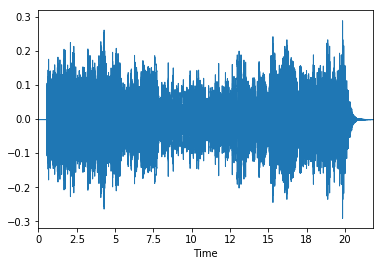

In [7]:
display.waveplot(timeSeries, sr=sampleRate)

In [8]:
ipd.Audio(timeSeries, rate=sampleRate)

# Spectrogramify

### CQT Form

In [9]:
cqtSpect = lr.cqt(timeSeries,
                  fmin=lr.midi_to_hz(21),
                  sr=sampleRate,
                  hop_length=512,
                  bins_per_octave=16, # "resolution within an 8ve"
                  n_bins=16 * 8)      # number of total bins
                 

In [10]:
cqtSpect.T.shape

(942, 128)

In [11]:
lr.midi_to_hz(21), lr.midi_to_hz(21 + 12 * 8)

(27.5, 7040.0)

/Users/Kamdori/.local/lib/python2.7/site-packages/librosa/core/spectrum.py:960: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


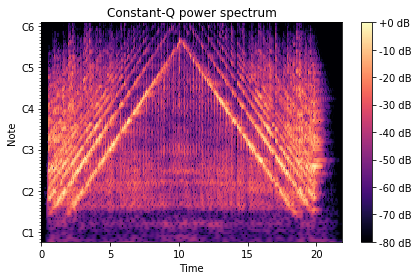

In [12]:
lr.display.specshow(lr.amplitude_to_db(cqtSpect, ref=np.max), \
                    sr=sampleRate, x_axis='time', y_axis='cqt_note', fmin=lr.midi_to_hz(21), bins_per_octave=24)
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.tight_layout()

In [13]:
# lr.display.specshow?

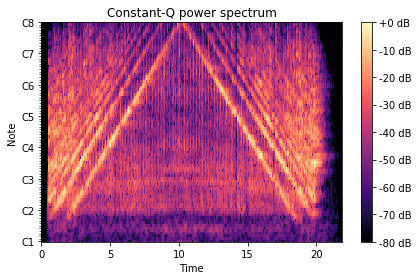

In [14]:
y, sr = lr.load(DATAPOINT)
C = lr.cqt(y, sr=sr)
lr.display.specshow(lr.amplitude_to_db(C, ref=np.max), \
                    sr=sampleRate, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.tight_layout()

In [15]:
C.T.shape

(942, 84)

In [16]:
C.dtype

dtype('complex128')

Generate ground truths:
+ Create ground truth range 
  --> SR from MAPS, Hop Length from...
  --> t = HL/SR
  --> np.arange(Num of Frames (from above)) * t

### STFT + Triangular Filterbank form

In [17]:
signal = mm.audio.signal.Signal(DATAPOINT, num_channels=1)
framedSignal = mm.audio.signal.FramedSignal(signal, frame_size=2048, hop_size=441)

In [18]:
signal.sample_rate

44100

In [29]:
stfttri = mm.audio.spectrogram.LogarithmicFilteredSpectrogram(
    DATAPOINT,
    num_bands=36,
    num_channels=1, 
    sr=44100,
    unique_filters=True,
    norm_filters=True,
    frame_size=4096,
    fft_size=4096,
    fps=100, # 31.25 trash
    fmin=30,
    fmax=8000.0,
    fref=440.0,
    circular_shift=False,
    hop_size=441.0)

In [30]:
print stfttri.min()
print stfttri.max()

0.0
2.0596635


In [31]:
stfttri = np.array(stfttri)
stfttri = lr.util.normalize(stfttri, norm=np.inf)

In [32]:
stfttri.shape

(2186, 185)

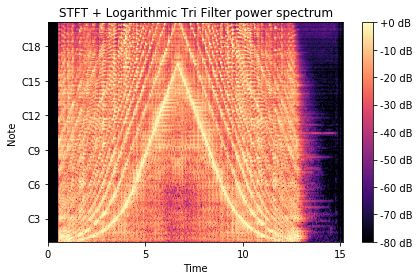

In [21]:
lr.display.specshow(
    lr.amplitude_to_db(stfttri, ref=np.max).T, 
    sr=44100,
    x_axis='time',
    y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT + Logarithmic Tri Filter power spectrum')
plt.tight_layout()

### Generate Ground Truths

For each column in transform
- Reshape.
  - np.abs, rescale to (0 to 1)
- Generate ground truth array
  - Times = np.arange(Nframes) * t
    - Where t = hopLength/sampleRate
  - Use associative .txt to check which pitches are on or off.
  - Output ground truth array with which notes are on or off
    - i.e. [0, 1, 0 , 0 , 0...]

Pad and Create Window

In [22]:
testArray = np.array([[1, 2],[3, 4]])
testArray

array([[1, 2],
       [3, 4]])

In [23]:
np.pad(testArray, ((1, 1), (0, 0)), 'constant')

array([[0, 0],
       [1, 2],
       [3, 4],
       [0, 0]])

(num_of_bins, time_steps)

In [24]:
times = lr.frames_to_time(
    np.arange(stfttri.shape[0]),
    sr=44100,
    hop_length=441.0
)

In [25]:
midi = pm.PrettyMIDI(MIDI_DATAPOINT)

In [26]:
expectedOutput = midi.get_piano_roll(fs=44100, times=times)[21:108+1].T
expectedOutput[expectedOutput > 0] = 1

In [27]:
expectedOutput[expectedOutput > 0] = 1

#### Sanity Check spectrogram + expected:

In [28]:
print stfttri.shape
print expectedOutput.shape
print times.shape

(1306, 229)
(1306, 88)
(1306,)


In [29]:
test_ticks = range(95,95+95)

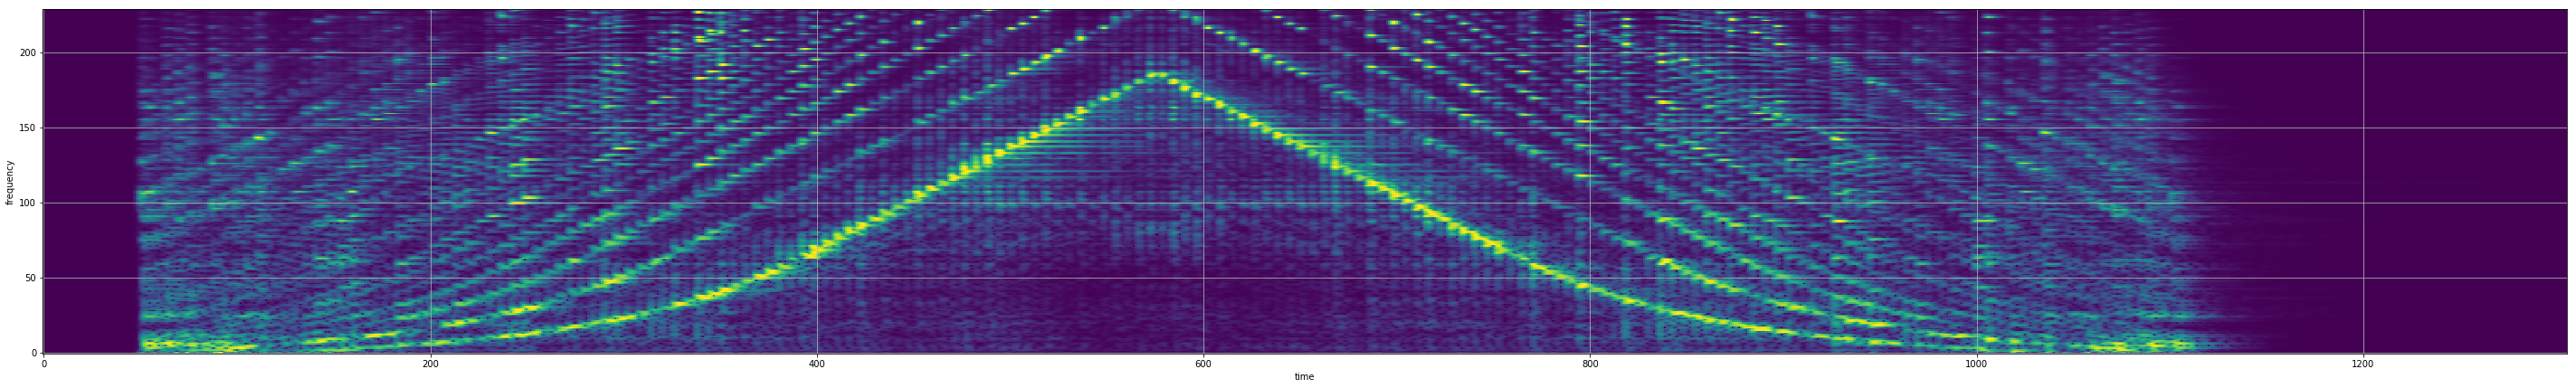

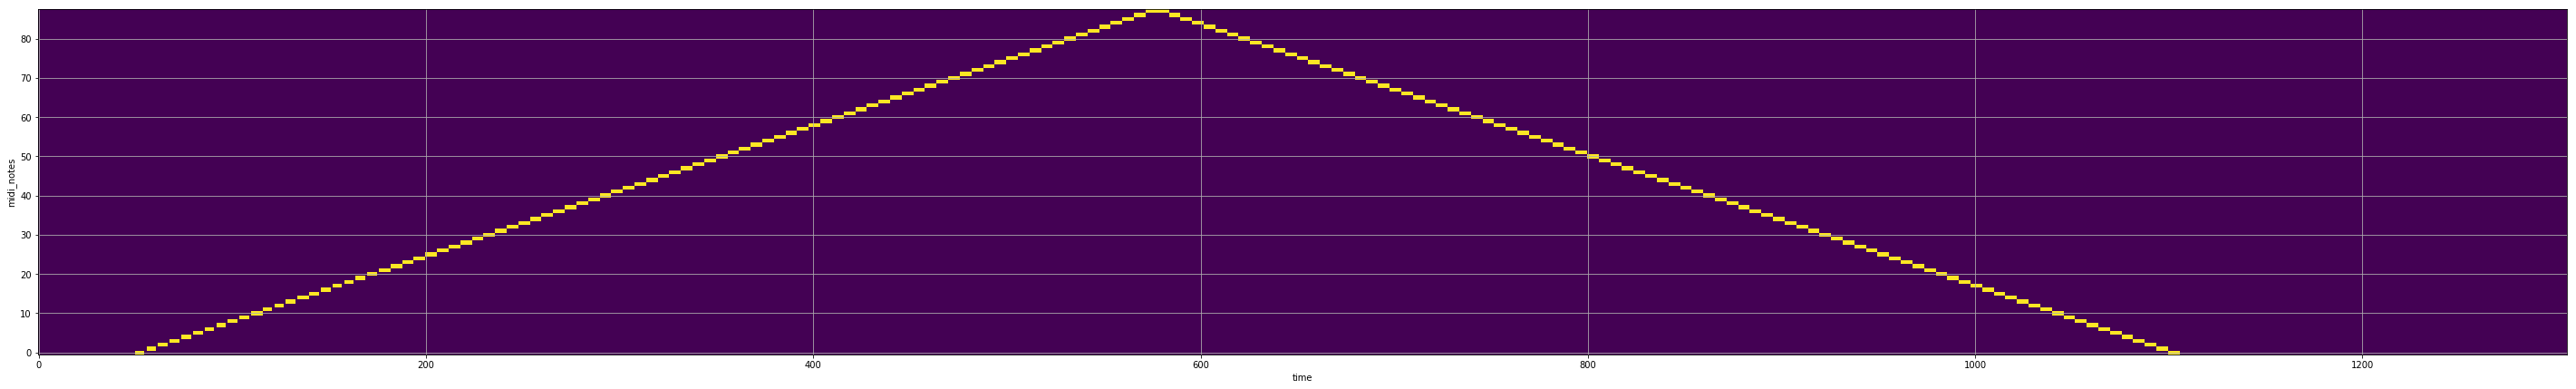

In [30]:
length = 50

fig = plt.figure(figsize=(length,7))
plt.grid()
plt.imshow(stfttri.T ,aspect='auto')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('frequency')
# plt.xticks(time_locs, times)
# plt.savefig('spect.png')
plt.show()
fig = plt.figure(figsize=(length,7))
plt.grid()
plt.imshow(expectedOutput.T ,aspect='auto')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('midi_notes')
# plt.xticks(time_locs, times)
# plt.savefig('ground.png')
plt.show()

## HCQT Form

In [31]:
def get_hcqt_params():
    """Hack to always use the same parameters :)
    """
    bins_per_octave = 60
    n_octaves = 6
    harmonics = [0.5, 1, 2, 3, 4, 5]
    sr = 22050
    fmin = 32.7
    hop_length = 256
    return bins_per_octave, n_octaves, harmonics, sr, fmin, hop_length

def compute_hcqt(path):
    (bins_per_octave, n_octaves, harmonics,
     sr, f_min, hop_length) = get_hcqt_params()
    
    y, fs = lr.load(path, sr=sr)
    
    cqt_list = []
    shapes = []
    for h in harmonics:
        cqt = lr.cqt(
                y,
                sr=fs,
                hop_length=hop_length,
                fmin=f_min*float(h),
                n_bins=bins_per_octave*n_octaves,
                bins_per_octave=bins_per_octave)
        cqt_list.append(cqt)
        shapes.append(cqt.shape)
    
    shapes_equal = [s == shapes[0] for s in shapes]
    if not all(shapes_equal):
        min_time = np.min([s[1] for s in shapes])
        new_cqt_list = []
        for i in range(len(cqt_list)):
            new_cqt_list.append(cqt_list[i][:, :min_time])
        cqt_list = new_cqt_list
        
    log_hcqt = ((1.0/80.0) * lr.core.amplitude_to_db(
        np.abs(np.array(cqt_list)), ref=np.max)) + 1.0
    return log_hcqt

In [32]:
log_hcqt = compute_hcqt(DATAPOINT)

In [33]:
"harmonics, time, frequencies"
log_hcqt.shape

(6, 360, 1125)

In [34]:
array = np.array([[1, 2], [1, 2], [1, 2]])
array.shape

(3, 2)

'MIN_MIDI' : 21,
'MAX_MIDI' : 108,

In [35]:
print lr.midi_to_hz(21)
print lr.midi_to_hz(108)
print lr.hz_to_note(lr.midi_to_hz(21))
print lr.hz_to_note(lr.midi_to_hz(108))

27.5
4186.009044809578
A0
C8


## NSynth WaveNet Form

In [82]:
audio, sr = lr.load(OTHER_DATAPOINT)
sr

22050

In [81]:
ipd.Audio(audio, rate=sr)

In [37]:
sample_length = y.shape[0]

In [83]:
sr

22050

In [84]:
print '{} samples, {} seconds'.format(sample_length, sample_length/float(sr))

287757 samples, 13.0502040816 seconds


#### Encode

In [85]:
%time encoding = fastgen.encode(audio, './wavenet-ckpt/model.ckpt-200000', sample_length)

INFO:tensorflow:Restoring parameters from ./wavenet-ckpt/model.ckpt-200000
CPU times: user 1min 54s, sys: 13.2 s, total: 2min 7s
Wall time: 10.9 s


In [86]:
encoding.shape

(1, 284, 16)

In [87]:
np.save(OTHER_DATAPOINT_NAME + '.npy', encoding)

Text(0.5,1,'NSynth Encoding')

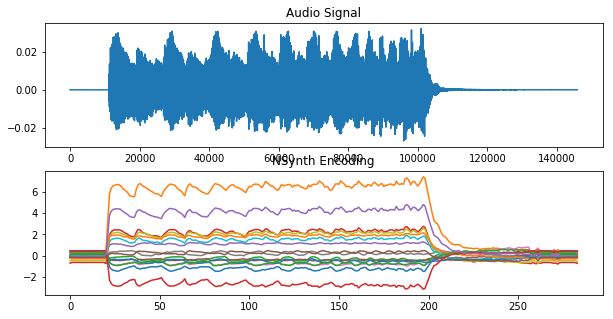

In [88]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].plot(audio);
axs[0].set_title('Audio Signal')
axs[1].plot(encoding[0]);
axs[1].set_title('NSynth Encoding')

In [ ]:
# Run this to generate synthesized sound
%time fastgen.synthesize( \
    encoding, \
    save_paths=['./gen_' + OTHER_DATAPOINT_NAME], \
    checkpoint_path='./wavenet-ckpt/model.ckpt-200000',\
    samples_per_save=sample_length)

INFO:tensorflow:Restoring parameters from ./wavenet-ckpt/model.ckpt-200000
INFO:tensorflow:Sample: 0
INFO:tensorflow:Saving: ./gen_MAPS_ISOL_TR1_M_S0_M40_AkPnBcht.wav
INFO:tensorflow:Sample: 100
INFO:tensorflow:Sample: 200
INFO:tensorflow:Sample: 300
INFO:tensorflow:Sample: 400
INFO:tensorflow:Sample: 500
INFO:tensorflow:Sample: 600
INFO:tensorflow:Sample: 700
INFO:tensorflow:Sample: 800
INFO:tensorflow:Sample: 900
INFO:tensorflow:Sample: 1000
INFO:tensorflow:Sample: 1100
INFO:tensorflow:Sample: 1200
INFO:tensorflow:Sample: 1300
INFO:tensorflow:Sample: 1400
INFO:tensorflow:Sample: 1500
INFO:tensorflow:Sample: 1600
INFO:tensorflow:Sample: 1700
INFO:tensorflow:Sample: 1800
INFO:tensorflow:Sample: 1900
INFO:tensorflow:Sample: 2000
INFO:tensorflow:Sample: 2100
INFO:tensorflow:Sample: 2200
INFO:tensorflow:Sample: 2300
INFO:tensorflow:Sample: 2400
INFO:tensorflow:Sample: 2500
INFO:tensorflow:Sample: 2600
INFO:tensorflow:Sample: 2700
INFO:tensorflow:Sample: 2800
INFO:tensorflow:Sample: 2900
I

INFO:tensorflow:Sample: 27300
INFO:tensorflow:Sample: 27400
INFO:tensorflow:Sample: 27500
INFO:tensorflow:Sample: 27600
INFO:tensorflow:Sample: 27700
INFO:tensorflow:Sample: 27800
INFO:tensorflow:Sample: 27900
INFO:tensorflow:Sample: 28000
INFO:tensorflow:Sample: 28100
INFO:tensorflow:Sample: 28200
INFO:tensorflow:Sample: 28300
INFO:tensorflow:Sample: 28400
INFO:tensorflow:Sample: 28500
INFO:tensorflow:Sample: 28600
INFO:tensorflow:Sample: 28700
INFO:tensorflow:Sample: 28800
INFO:tensorflow:Sample: 28900
INFO:tensorflow:Sample: 29000
INFO:tensorflow:Sample: 29100
INFO:tensorflow:Sample: 29200
INFO:tensorflow:Sample: 29300
INFO:tensorflow:Sample: 29400
INFO:tensorflow:Sample: 29500
INFO:tensorflow:Sample: 29600
INFO:tensorflow:Sample: 29700
INFO:tensorflow:Sample: 29800
INFO:tensorflow:Sample: 29900
INFO:tensorflow:Sample: 30000
INFO:tensorflow:Sample: 30100
INFO:tensorflow:Sample: 30200
INFO:tensorflow:Sample: 30300
INFO:tensorflow:Sample: 30400
INFO:tensorflow:Sample: 30500
INFO:tenso

INFO:tensorflow:Sample: 54700
INFO:tensorflow:Sample: 54800
INFO:tensorflow:Sample: 54900
INFO:tensorflow:Sample: 55000
INFO:tensorflow:Sample: 55100
INFO:tensorflow:Sample: 55200
INFO:tensorflow:Sample: 55300
INFO:tensorflow:Sample: 55400
INFO:tensorflow:Sample: 55500
INFO:tensorflow:Sample: 55600
INFO:tensorflow:Sample: 55700
INFO:tensorflow:Sample: 55800
INFO:tensorflow:Sample: 55900
INFO:tensorflow:Sample: 56000
INFO:tensorflow:Sample: 56100
INFO:tensorflow:Sample: 56200
INFO:tensorflow:Sample: 56300
INFO:tensorflow:Sample: 56400
INFO:tensorflow:Sample: 56500
INFO:tensorflow:Sample: 56600
INFO:tensorflow:Sample: 56700
INFO:tensorflow:Sample: 56800
INFO:tensorflow:Sample: 56900
INFO:tensorflow:Sample: 57000
INFO:tensorflow:Sample: 57100
INFO:tensorflow:Sample: 57200
INFO:tensorflow:Sample: 57300
INFO:tensorflow:Sample: 57400
INFO:tensorflow:Sample: 57500
INFO:tensorflow:Sample: 57600
INFO:tensorflow:Sample: 57700
INFO:tensorflow:Sample: 57800
INFO:tensorflow:Sample: 57900
INFO:tenso

INFO:tensorflow:Sample: 82100
INFO:tensorflow:Sample: 82200
INFO:tensorflow:Sample: 82300
INFO:tensorflow:Sample: 82400
INFO:tensorflow:Sample: 82500
INFO:tensorflow:Sample: 82600
INFO:tensorflow:Sample: 82700
INFO:tensorflow:Sample: 82800
INFO:tensorflow:Sample: 82900
INFO:tensorflow:Sample: 83000
INFO:tensorflow:Sample: 83100
INFO:tensorflow:Sample: 83200
INFO:tensorflow:Sample: 83300
INFO:tensorflow:Sample: 83400
INFO:tensorflow:Sample: 83500
INFO:tensorflow:Sample: 83600
INFO:tensorflow:Sample: 83700
INFO:tensorflow:Sample: 83800
INFO:tensorflow:Sample: 83900
INFO:tensorflow:Sample: 84000
INFO:tensorflow:Sample: 84100
INFO:tensorflow:Sample: 84200
INFO:tensorflow:Sample: 84300
INFO:tensorflow:Sample: 84400
INFO:tensorflow:Sample: 84500
INFO:tensorflow:Sample: 84600
INFO:tensorflow:Sample: 84700
INFO:tensorflow:Sample: 84800
INFO:tensorflow:Sample: 84900
INFO:tensorflow:Sample: 85000
INFO:tensorflow:Sample: 85100
INFO:tensorflow:Sample: 85200
INFO:tensorflow:Sample: 85300
INFO:tenso

#### Decode

Generate ground truth against embeddings and transformed synthetic .wav

In [ ]:
# Synthetic (sounds slower)
SYNTH_AUDIO = './gen_' + OTHER_DATAPOINT_NAME
synthetic_audio, sr = lr.load(SYNTH_AUDIO, sr=16000)
ipd.Audio(synthetic_audio, rate=16000)

In [ ]:
# Original
audio, sr = lr.load(OTHER_DATAPOINT, sr=16000)
ipd.Audio(audio, rate=16000)

In [ ]:
def log_filt(path):
    return  mm.audio.spectrogram.LogarithmicFilteredSpectrogram(
        path,
        num_bands=48,
        num_channels=1, 
        sr=16000,
        unique_filters=True,
        norm_filters=True,
        frame_size=4096,
        fft_size=4096,
        fps=100,
        fmin=30,
        fmax=8000.0,
        fref=440.0,
        circular_shift=False,
        hop_size=441.0)

def display(stfttri):
    lr.display.specshow(
    lr.amplitude_to_db(stfttri, ref=np.max).T, 
    sr=16000,
    x_axis='time',
    y_axis='cqt_note')
    plt.colorbar(format='%+2.0f dB')
    plt.title('STFT + Logarithmic Tri Filter power spectrum')
    plt.tight_layout()

In [ ]:
# Test Normalization
scaler = MinMaxScaler()
scaler = scaler.fit(encoding[0])
normalized_encoding = scaler.transform(encoding[0])
min = np.min(encoding[0])
max = np.max(encoding[0])
normalized_encoding = encoding[0]
for i, _ in enumerate(normalized_encoding):
    for j, _ in enumerate(normalized_encoding[i]):
        normalized_encoding[i][j] = (normalized_encoding[i][j] - min) / (max - min)
# normalized_encoding /= np.max(encoding[0], axis=0)
# normalized_encoding = lr.util.normalize(encoding[0])

In [ ]:
# Synthetic
synth_log_filt = lr.util.normalize(log_filt(SYNTH_AUDIO))
print synth_log_filt.shape
display(synth_log_filt)

times = lr.frames_to_time(np.arange(synth_log_filt.shape[0]), sr=16000)
midi = pm.PrettyMIDI(OTHER_MIDI_DATAPOINT)
expected = midi.get_piano_roll(fs=16000, times=times)[21:108+1].T
expected[expected > 0] = 1
print expected.shape

# .wav vs Grount Truth
times = lr.frames_to_time(np.arange(encoding[0].shape[0]), sr=21500)
midi = pm.PrettyMIDI(OTHER_MIDI_DATAPOINT)
expected = midi.get_piano_roll(fs=21500, times=times)[21:108+1].T
expected[expected > 0] = 1

fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].plot(normalized_encoding);
axs[0].set_title('Normalized NSynth Encoding')
axs[1].plot(encoding[0])
axs[1].set_title('NSynth Encoding')

fig = plt.figure(figsize=(10,5))
plt.grid()
plt.imshow(encoding[0].T ,aspect='auto')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('latent_factors')
plt.show()

fig = plt.figure(figsize=(10,5))
plt.grid()
plt.imshow(expected.T ,aspect='auto')
plt.gca().invert_yaxis()
fig.axes[0].set_xlabel('time')
fig.axes[0].set_ylabel('midi_notes')
plt.show()

print encoding[0].shape
print expected.shape

In [ ]:
print np.min(encoding)
print np.max(encoding)

In [ ]:
# Original
orig_log_filt = lr.util.normalize(log_filt(OTHER_DATAPOINT))
print orig_log_filt.shape
display(orig_log_filt)

Visualize alignment of embeddings and synthetic.

#### WTS Embedding aligns with Ground Truth. 
- i.e. same amount of time frames. frequencies/energy align.
- Normalize scale of time in encoding to scale of time in ground truth
- Check number frames between spect and encoding
- Check synth_amplitude with ground truth i.e. energy when notes are on.